## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [521]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [522]:
# Random state seed
rseed = 42

## Load and explore data

In [523]:
# Import the dataset
df = pd.read_csv('Country-data.csv ')
# Display the first few rows of the dataset
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [524]:
# Check the shape
df.shape

(167, 10)

In [525]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [526]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [527]:
# Identify any missing data
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [528]:
# Drop any non-numeric features (columns)
df_numeric = df.drop(columns=['country'])
# Display the first few rows of the dataset
df_numeric.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


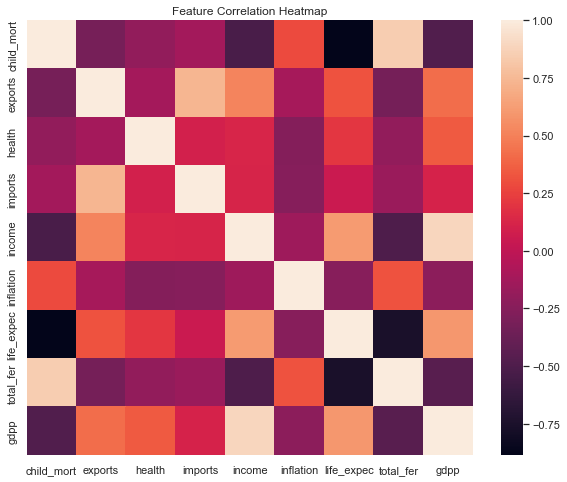

In [529]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
# Compute correlation matrix
corr_matrix = df_numeric.corr()
# Set up new figure for plotting
plt.figure(figsize=(10, 8))
# Create a heatmap
sns.heatmap(corr_matrix)
# Display title to the heatmap
plt.title("Feature Correlation Heatmap")
# Display the final heatmap
plt.show()

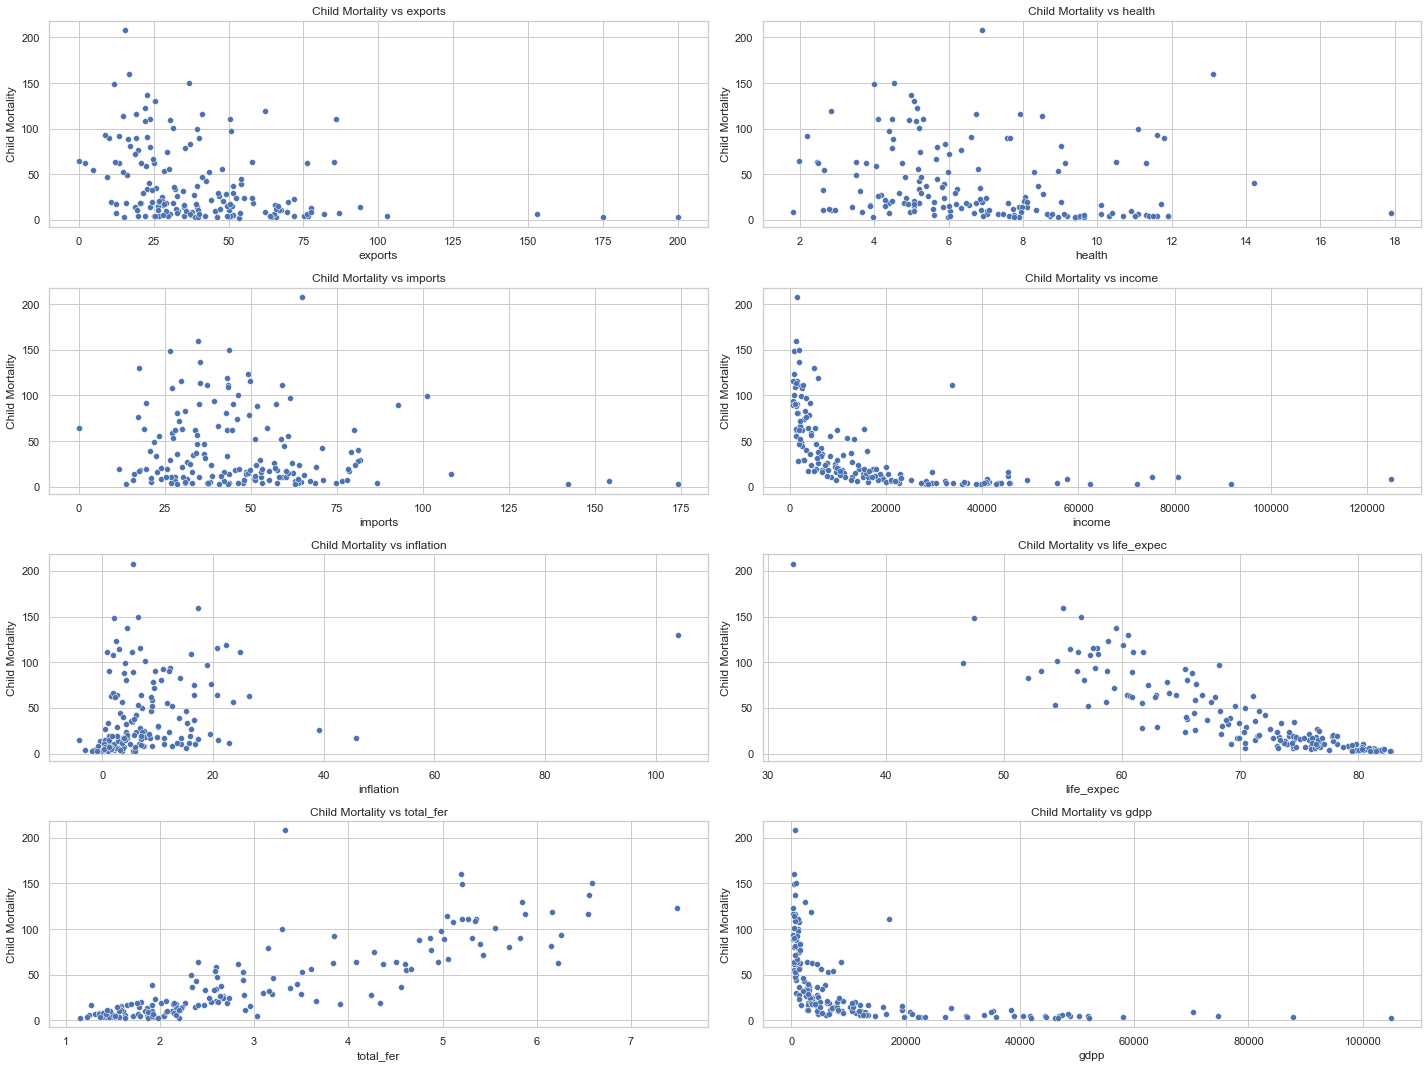

In [530]:
# Explore the continuous independent features against child_mort using scatter plots.
# Assign the target variable
target = 'child_mort'
# List of all feature names, excluding the target column
features = [col for col in df_numeric.columns if col != target]
# Set up new figure for plotting
plt.figure(figsize=(20, 15))
# Loop through each feature
for i, feature in enumerate(features):
    # Create a 4×2 subplots
    plt.subplot(4, 2, i + 1)
    # Create a scatter plot for the current feature
    sns.scatterplot(x=df_numeric[feature], y=df_numeric[target])
    # Display the x-axis
    plt.xlabel(feature)
    # Display the y-axis
    plt.ylabel("Child Mortality")
    # Display the title of the plot
    plt.title(f"Child Mortality vs {feature}")
# Adjust the layout of the subplots
plt.tight_layout()
# Display the final plot
plt.show()

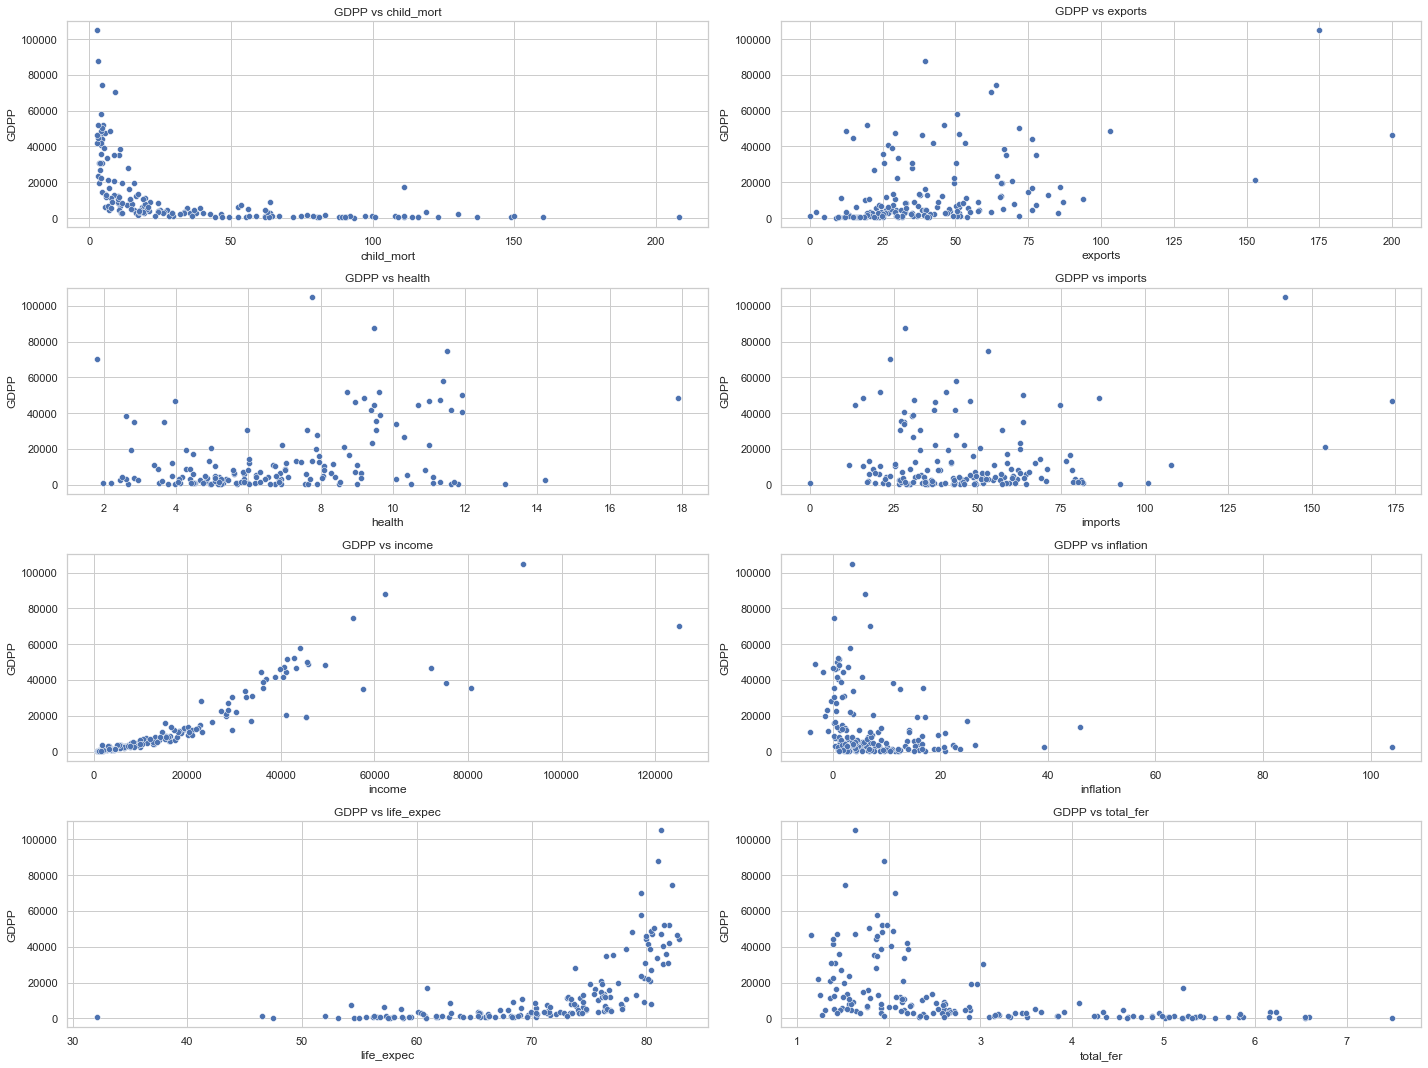

In [531]:
# Explore the continuous independent features against gdpp using scatter plots.
# Assign the target variable
target = 'gdpp'
# List of all feature names, excluding the target column
features = [col for col in df_numeric.columns if col != target]
# Set up new figure for plotting
plt.figure(figsize=(20, 15))
# Loop through each feature
for i, feature in enumerate(features):
    # Create a 4×2 subplots
    plt.subplot(4, 2, i + 1)
    # Create a scatter plot for the current feature
    sns.scatterplot(x=df_numeric[feature], y=df_numeric[target])
    # Display the x-axis
    plt.xlabel(feature)
    # Display the y-axis
    plt.ylabel("GDPP")
    # Display the title of the plot
    plt.title(f"GDPP vs {feature}")
# Adjusts the layout of the subplots
plt.tight_layout()
# Display the final plot
plt.show()

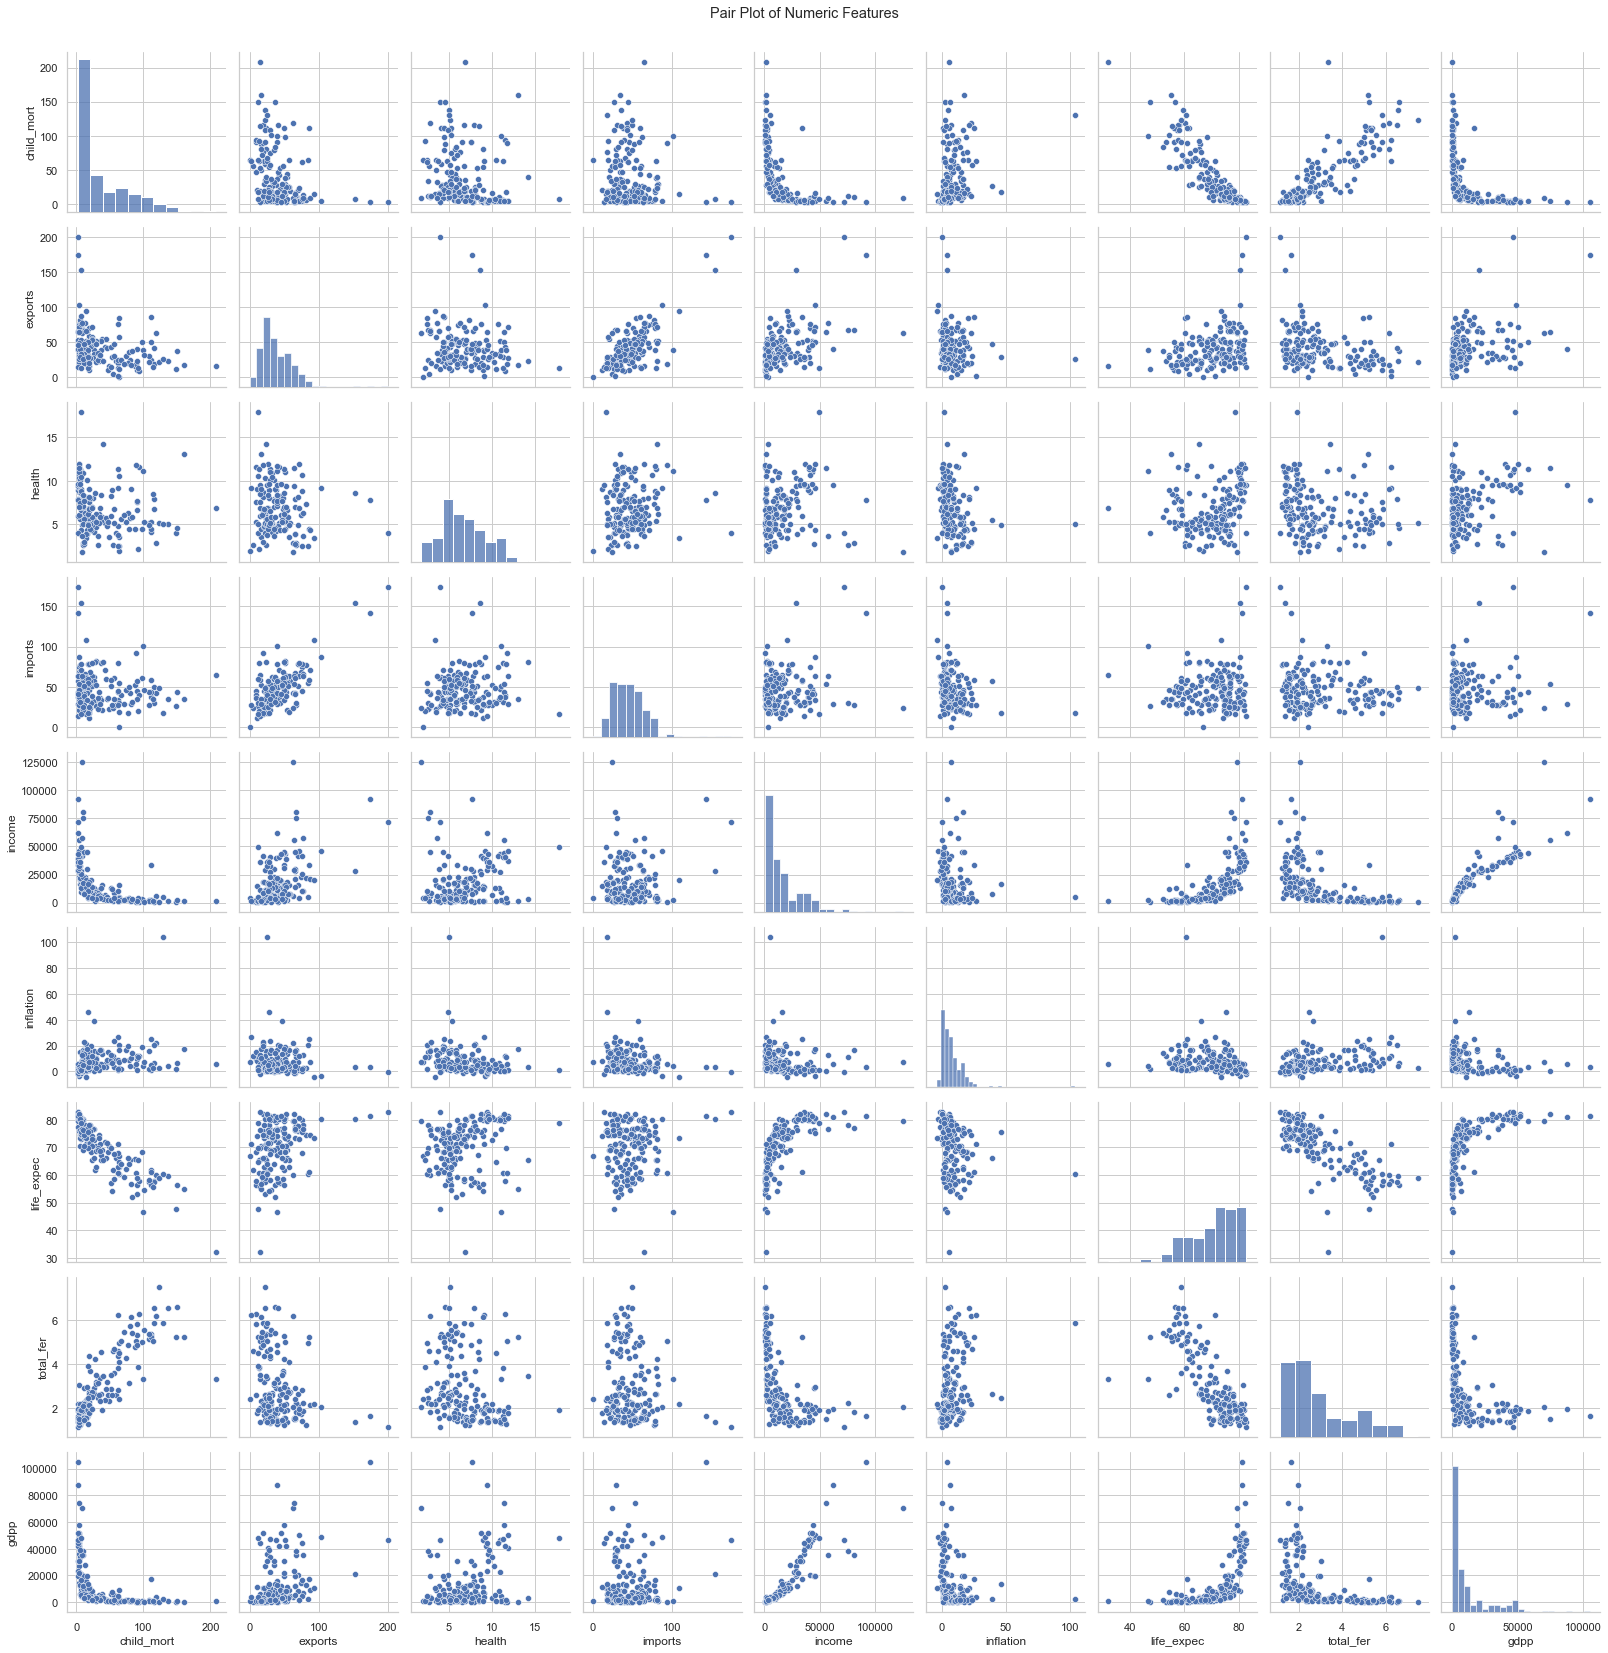

In [532]:
# Create a pair plot
sns.pairplot(df_numeric)
# Display the title of the plot
plt.suptitle("Pair Plot of Numeric Features", y=1.02)
# Adjust the layout of the subplots
plt.tight_layout()
# Display the final plot
plt.show()
# Hint: Explore seaborn pairplot

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

Child Mortality compared to GDP per capita shows clear separation trends, indicating that these features are likely valuable for clustering. This relationship appears to be the most promising for clustering purposes due to its strong, nonlinear inverse pattern and distinct groupings. As GDP per capita increases, child mortality decreases sharply, with a clear division into low, middle, and high development groups.

Income to GDP per capita also displays clear separation trends, suggesting that these features may help in clustering. There is a positive correlation; higher income is associated with higher GDP per capita, which may result in clear vertical separation.

Life Expectancy versus GDP per capita exhibits structured patterns as well. Life expectancy rises with GDP per capita, and the trend flattens at higher values, displaying good separation between low and high GDP per capita ranges.

### Scaling the Data

In [533]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
# Creates the MinMaxScaler
scaler = MinMaxScaler()
# Fit the scaler to the numeric data and transform it
scaled_data = scaler.fit_transform(df_numeric)
# Convert scaled data back into a DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_numeric.columns)
# Display the first few rows of the scaled dataframe
df_scaled.head()
# df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

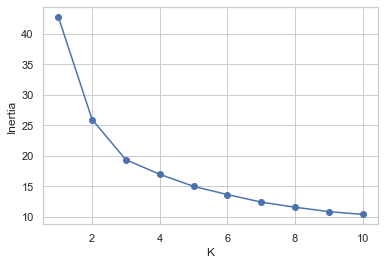

In [534]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

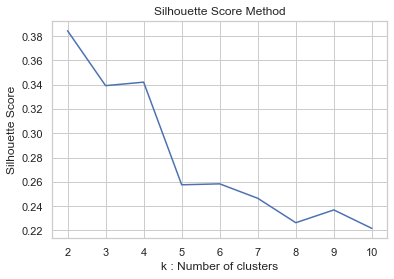

In [535]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

The elbow ranges from K=2 to K=4, with the highest silhouette score at K=2, indicating that the optimal value for K is 2.

## Fitting a K-Means Model with the selected K value

In [536]:
# Remember to set the random_state to rseed
# Create a KMeans clustering model
kmeans = KMeans(n_clusters=2, random_state=42)
# Fit the model to the scaled data and predict the cluster labels
cluster_labels = kmeans.fit_predict(df_scaled)

In [537]:
# Count the number of records in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
# Display the cluster counts
print(cluster_counts)

0    116
1     51
dtype: int64


In [538]:
# Check model performance with the silhouette coefficient
# Calculate the silhouette score
score = silhouette_score(df_scaled, cluster_labels)
# Display the silhouette score
print("Silhouette Score:", score)

Silhouette Score: 0.384471920619431


## Predictions

In [539]:
# Add the predicted cluster label column to the original dataframe
df['Cluster'] = cluster_labels
# Display the first few rows of the dataframe with the cluster labels
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


## Visualisation of clusters

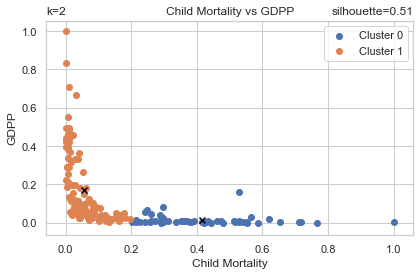

In [540]:
# Visualisation of clusters: child mortality vs gdpp
# Select only child_mort and gdpp columns from the scaled DataFrame
X = df_scaled[['child_mort', 'gdpp']].values.reshape(-1,2)
# Define a function to run KMeans and plot
def scatter_Kmeans(x, k, r=42):
    # Initialise a KMeans model
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    # Fit the model and predict the cluster labels
    y_pred = kmeans.fit_predict(x)
    for c in range(k):
      # Plot each cluster
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], label = 'Cluster {}'.format(c))
      # Plot the cluster centers
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    # Calculate the silhouette score
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 2)
    # Display the silhouette score
    plt.title('silhouette={}'.format(score), loc='right')
    # Display the k value of the plot
    plt.title('k={}'.format(k), loc='left')
    # Display the title of the plot
    plt.title('Child Mortality vs GDPP')
    # Display the x-axis
    plt.xlabel('Child Mortality')
    # Display the y-axis
    plt.ylabel('GDPP')
    # Display the legend
    plt.legend()
    # Adjust the layout of the plot
    plt.tight_layout()
    # Display the final plot
    plt.show()
# Call the function to plot the clusters
scatter_Kmeans(X, k=2, r=0)

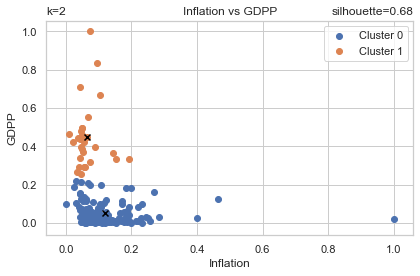

In [541]:
# Visualisation of clusters: inflation vs gdpp
# Select only inflation and gdpp columns from the scaled DataFrame
X = df_scaled[['inflation', 'gdpp']].values.reshape(-1,2)
# Define a function to run KMeans and plot
def scatter_Kmeans(x, k, r=42):
    # Initialise a KMeans model
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    # Fit the model and predict the cluster labels
    y_pred = kmeans.fit_predict(x)
    for c in range(k):
      # Plot each cluster
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], label = 'Cluster {}'.format(c))
      # Plot the cluster centers
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    # Calculate the silhouette score
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 2)
    # Display the silhouette score
    plt.title('silhouette={}'.format(score), loc='right')
    # Display the k value of the plot
    plt.title('k={}'.format(k), loc='left')
    # Display the title of the plot
    plt.title('Inflation vs GDPP')
    # Display the x-axis
    plt.xlabel('Inflation')
    # Display the y-axis
    plt.ylabel('GDPP')
    # Display the legend
    plt.legend()
    # Adjust the layout of the plot
    plt.tight_layout()
    # Display the final plot
    plt.show()
# Call the function to plot the clusters
scatter_Kmeans(X, k=2, r=0)

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

Based on the interpretation of economic indicators, high GDP per capita, low child mortality, and low, stable inflation are characteristics of high-income or developed countries, while the opposite suggests characteristics of low-income or least developed countries.

Cluster 0 exhibits high child mortality, low GDP per capita, and high, unstable inflation, indicating that it likely represents low-income or least developed countries.

In contrast, Cluster 1 showcases low child mortality, high GDP per capita, and low, stable inflation, which suggests that it likely reflects high-income or developed countries.

In [542]:
# Replace numerical cluster labels with meaningful ones
# Convert cluster labels to a NumPy array
cluster_labels = np.array(cluster_labels)
# Create a mapping dictionary for cluster labels
label_map = {0: 'Least Developed', 1: 'Developed'}
# Map the numerical labels to meaningful labels
df['Cluster_Label'] = df['Cluster'].map(label_map)
# Display the first few rows of the dataframe with the new cluster labels
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster,Cluster_Label
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1,Developed
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,Least Developed
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,Least Developed
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1,Developed
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,Least Developed
